In [295]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import streamlit as st
from sklearn.metrics import classification_report
# from sklearn.utils.validation import check_is_fitted



In [251]:
# Data Cleaning & Preprocessing
def wrangle(filename):
    df = pd.read_excel(filename)
    df = df.dropna()
    # Ensure InvoiceNo is string so .str works
    df["InvoiceNo"] = df["InvoiceNo"].astype(str)
    # Remove rows where InvoiceNo starts with 'C'
    df = df[~df["InvoiceNo"].str.startswith("C")].copy()
    # Focus Analysis on the UK
    df_uk = df[df['Country'] == 'United Kingdom'].copy()
    # Create new feature: TotalCost = Quantity × UnitPrice
    df_uk["TotalCost"] = df_uk["Quantity"] * df_uk["UnitPrice"]
    # slice TotalCost of 500
    df_uk = df_uk[df_uk['TotalCost'] <= 500]
    #slice by quantity of 100
    df_uk = df_uk[df_uk['Quantity'] <= 100]
    df = df_uk.reset_index(drop=True)
    return df

def create_rfm(df):
    """
    Create Recency, Frequency, and Monetary features per customer.
    df: Cleaned transaction DataFrame with columns:
        CustomerID, InvoiceDate, InvoiceNo, TotalCost
    Returns:
        rfm DataFrame indexed by CustomerID
    """
    # Make sure InvoiceDate is datetime
    df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
    # The reference date is one day after the last purchase
    snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)
    rfm = (
        df.groupby("CustomerID")
        .agg(
            Recency=("InvoiceDate", lambda x: (snapshot_date - x.max()).days),
            Frequency=("InvoiceNo", "nunique"),
            Monetary=("TotalCost", "sum")
        )
    ).reset_index()
    rfm.columns = ["CustomerID", "Recency", "Frequency", "Monetary"]
    return rfm
df=wrangle("../data/online_retail.xlsx")
rfm_df=create_rfm(df)



In [301]:
#EDA Basic structure, summary, key features
# print(df.info())
rfm_df.head()
# print(rfm_df.info())
# print(df.describe())
# compare_quantity_TotalCost = df[["Quantity", "TotalCost"]].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
# print(compare_quantity_TotalCost)

,CustomerID,Recency,Frequency,Monetary,Anomaly_ISO,Anomaly_LOF
0,12747.0,2,11,4196.01,0,0
1,12748.0,1,208,30278.53,1,1
2,12749.0,4,5,4090.88,0,0
3,12820.0,3,4,942.34,0,0
4,12821.0,214,1,92.72,0,0


In [194]:
# EDA Distributions of key features
# Histogram of monetary values
# plt.figure(figsize=(10,6))
# sns.histplot(df['TotalCost'], bins=50)
# plt.xlim(0, 500)  # optional: limit x-axis to focus on the bulk of data
# plt.title('TotalCost Distribution')
# plt.grid(False)
# plt.show()

# Quantity distribution
# sns.boxplot(x=df['Quantity'])
# plt.title('Quantity Boxplot')
# plt.show()

# Visualize where the extreme points are and how many there are.
# fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# sns.boxplot(y="Quantity", data=df, ax=axes[0])
# axes[0].set_title("Quantity")
# sns.boxplot(y="TotalCost", data=df, ax=axes[1])
# axes[1].set_title("TotalCost")
# plt.tight_layout()
# plt.show()


# Time-based patterns(monthly revenue)
# df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
# df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
# monthly_sales = df.groupby('InvoiceMonth')['TotalCost'].sum()
# monthly_sales.plot(kind='bar', figsize=(10,4), title='Monthly Revenue')
# plt.ylabel('Revenue')
# plt.show()

# Customer behavior (use your RFM table)
# Pairplot to view relationships
# sns.pairplot(rfm_df)
# plt.show()

# Correlations
# print(rfm_df.corr())
# sns.heatmap(rfm_df.corr(), annot=True, cmap="Blues")
# plt.title("Correlation Heatmap of RFM Features")
# plt.show()

# Top products from uk
# top_products = (df.groupby('Description')['Quantity']
#                   .sum()
#                   .sort_values(ascending=False)
#                   .head(10))
# top_products.plot(kind='barh', title='Top 10 Products by Quantity')
# plt.xlabel('Total Quantity')
# plt.show()

# top_countries = df['Country'].value_counts().head(10)
# top_countries.plot(kind='bar', title='Top Countries by Transactions')
# plt.ylabel('Number of Transactions')
# plt.show()

In [287]:
# Dimensionality Reduction, Standardize data (z-score scaling)

X = rfm_df[["Recency", "Frequency", "Monetary"]]
# X.head()

# iniate standardize Scaler
s_scaler = StandardScaler()

inertia_scores = []
silhouette_scores = []
n_clusters = range(2, 11)
for k in n_clusters:
    km_model = make_pipeline(s_scaler, KMeans(n_clusters=k, random_state=42))
    km_model.fit(X)
    inertia_scores.append(km_model.named_steps["kmeans"].inertia_)
    silhouette_scores.append(silhouette_score(X, km_model.named_steps["kmeans"].labels_))

# print("inertia_scores type:", type(inertia_scores))
# print("inertia_scores len:", len(inertia_scores))
print("inertia_scores:", inertia_scores)
print()
# print("silhouette scores type:", type(silhouette_scores))
# print("silhouette scores len:", len(silhouette_scores))
print("silhouette scores:", silhouette_scores)


# plot inertia_scores vs n_clusters
fig = px.line(x=n_clusters, y=inertia_scores, title="K-Means model: Inertia vs Number of Clusters")
fig.update_layout(xaxis_title="Number of Clusters (K)", yaxis_title="Inertia")
fig.show()

# plot silhouette_scores vs n_clusters
fig = px.line(x=n_clusters, y=silhouette_scores)
fig.update_layout(xaxis_title="Number of Clusters (K)", yaxis_title="silhouette scores")
fig.show()

# Inertia elbow around k=4 → model fit keeps improving until 4.
# Silhouette is best at k=2 (0.90) and good at k=3 (0.67), but almost zero at k=4.
# Conclusion: 2–3 clusters give good separation


inertia_scores: [8050.694304882067, 6143.172968877961, 3262.7001496114453, 2725.360497222616, 2238.99279860762, 1853.3256326158973, 1553.7779115808537, 1357.0470190936642, 1217.2104692573694]

silhouette scores: [0.8994479323540906, 0.6744471190810768, 0.02414383827656872, 0.05969967434976525, 0.08884686614313422, -0.01218737050540613, 0.059927588118938606, 0.05725329183187209, -0.026182999725232838]


In [286]:
# Applying PCA to reduce to 2 components (for 2-D plotting)
pca = PCA(n_components=2, random_state=42)
X_t = pca.fit_transform(X)
X_pca = pd.DataFrame(X_t, columns=["PC1", "PC2"])
final_model = make_pipeline(s_scaler, KMeans(n_clusters=3, random_state=42))
final_model.fit(X)

i = final_model.named_steps["kmeans"].inertia_
labels = final_model.named_steps["kmeans"].labels_

# scatter plot of PCA
fig = px.scatter(X_pca, x="PC1", y="PC2", color=labels, title="PCA representation of clusters")
fig.update_layout(xaxis_title="PC1", yaxis_title="PC2")
fig.show()
X_pca.head()

,PC1,PC2
0,2728.347412,-71.454716
1,28810.520227,106.861892
2,2623.197026,-70.136279
3,-525.258443,-92.963129
4,-1376.322426,112.156922


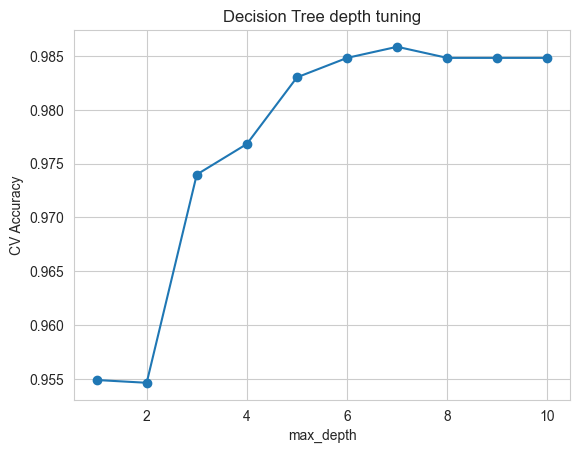

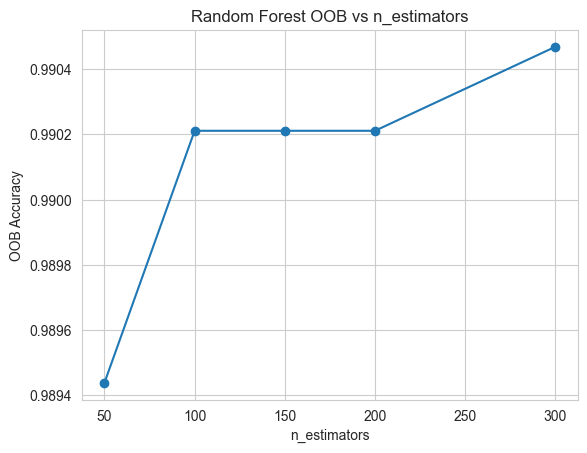

 Best hyper-parameter values: {'max_depth': 8, 'n_estimators': 100}


In [285]:
# Treat cluster labels as “pseudo-labels” and train a supervised model.
X = rfm_df[["Recency", "Frequency", "Monetary"]] # predictors
y = labels # pseudo-labels

# Itreate to find the best hyperpameter(max_depth, n_estimators) for our model
# Decision Tree, find max_depth

depths = range(1, 11)
cv_scores = []

for d in depths:
    dt = DecisionTreeClassifier(max_depth=d, random_state=42)
    scores = cross_val_score(dt, X, y, cv=5)   # 5-fold CV
    cv_scores.append(scores.mean())

plt.plot(depths, cv_scores, marker='o')
plt.xlabel("max_depth")
plt.ylabel("CV Accuracy")
plt.title("Decision Tree depth tuning")
plt.show()


# Random Forest, finding n_estimators
n_estimators = [50, 100, 150, 200, 300]
rf_scores = []

for n in n_estimators:
    rf = RandomForestClassifier(n_estimators=n, random_state=42, oob_score=True, n_jobs=-1)
    rf.fit(X, y)
    rf_scores.append(rf.oob_score_)

plt.plot(n_estimators, rf_scores, marker='o')
plt.xlabel("n_estimators")
plt.ylabel("OOB Accuracy")
plt.title("Random Forest OOB vs n_estimators")
plt.show()

# GridSearchCV for concrete confirmation
param_grid = {"max_depth": [None, 4, 6, 8],
              "n_estimators": [100, 150, 200]}
grid = GridSearchCV(RandomForestClassifier(random_state=42),
                    param_grid, cv=5, n_jobs=-1)
grid.fit(X, y)
print(f" Best hyper-parameter values:", grid.best_params_)

Accuracy: 0.9845559845559846
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       642
           1       0.97      0.94      0.95       131
           2       1.00      1.00      1.00         4

    accuracy                           0.98       777
   macro avg       0.99      0.98      0.98       777
weighted avg       0.98      0.98      0.98       777

Recency      0.152284
Frequency    0.484854
Monetary     0.362862
dtype: float64


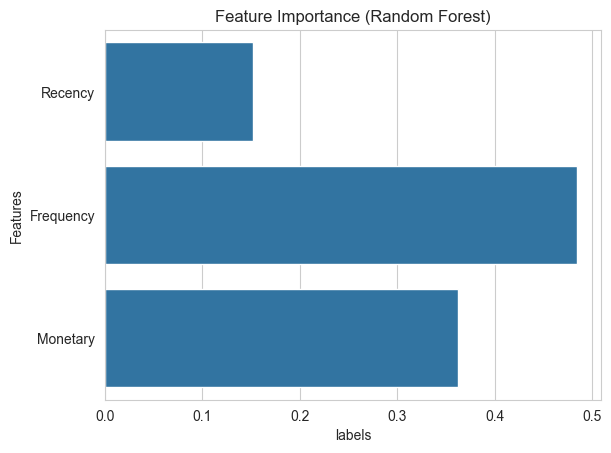

In [298]:
# Build final rf-Model

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

rf_final = RandomForestClassifier(
    max_depth=8,
    n_estimators=100,
    random_state=42,
    oob_score=True,      # optional but nice for final check
    n_jobs=-1
)
rf_final.fit(X_train, y_train)

y_pred = rf_final.predict(X_test)
print("Accuracy:", rf_final.score(X_test, y_test))
print(classification_report(y_test, y_pred))

# Feature Importance
importances = pd.Series(rf_final.feature_importances_, index=X.columns)
print(importances)
sns.barplot(x=importances, y=importances.index)
plt.title("Feature Importance (Random Forest)")
plt.ylabel("Features")
plt.xlabel("labels")
plt.show()

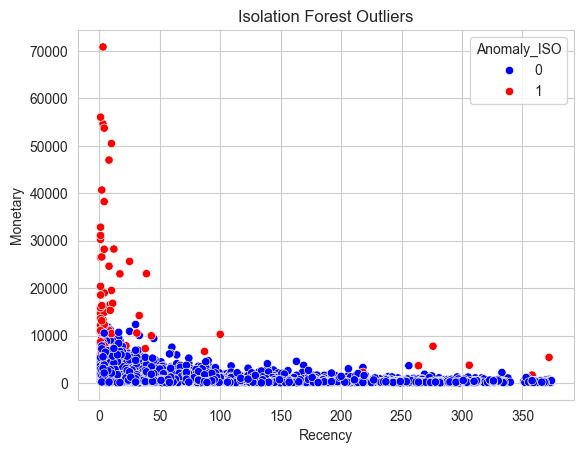

In [288]:
from sklearn.preprocessing import StandardScaler

X = rfm_df[["Recency", "Frequency", "Monetary"]]
X_scaled = StandardScaler().fit_transform(X)

from sklearn.ensemble import IsolationForest

iso = IsolationForest(
    n_estimators=100,        # number of trees
    contamination=0.02,      # ~2% of customers are expected outliers
    random_state=42
)
iso.fit(X_scaled)

# -1 = anomaly, 1 = normal
rfm_df["Anomaly_ISO"] = iso.predict(X_scaled)
rfm_df["Anomaly_ISO"] = rfm_df["Anomaly_ISO"].map({1:0, -1:1})  # 1 = outlier for clarity

from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=0.02
)
rfm_df["Anomaly_LOF"] = (lof.fit_predict(X_scaled) == -1).astype(int)

import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(
    x="Recency", y="Monetary",
    hue="Anomaly_ISO", data=rfm_df,
    palette={0:"blue", 1:"red"}
)
plt.title("Isolation Forest Outliers")
plt.show()


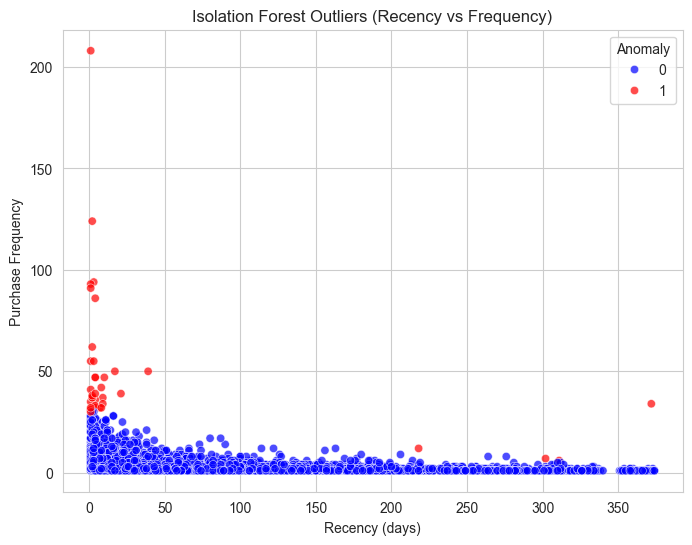

In [300]:


iso = IsolationForest(contamination=0.01, random_state=42)
rfm_df["Anomaly_ISO"] = iso.fit_predict(rfm_df[["Recency", "Frequency"]])
# Map to 0 = normal, 1 = anomaly
rfm_df["Anomaly_ISO"] = rfm_df["Anomaly_ISO"].map({1: 0, -1: 1})


plt.figure(figsize=(8,6))
sns.scatterplot(
    x="Recency", y="Frequency",
    hue="Anomaly_ISO", data=rfm_df,
    palette={0: "blue", 1: "red"}, alpha=0.7
)
plt.title("Isolation Forest Outliers (Recency vs Frequency)")
plt.xlabel("Recency (days)")
plt.ylabel("Purchase Frequency")
plt.legend(title="Anomaly")
plt.show()

